In [1]:
# Loading All Relevant Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ydata_profiling import ProfileReport
import dexplot as dxp
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [2]:
# Loading Dataset into a pandas dataframe

indicators_df = pd.read_csv("heart_2020_cleaned.csv")
indicators_df.head()


HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No              No    Yes             0.0   
2           No  26.58     Yes              No     No            20.0   
3           No  24.21      No              No     No             0.0   
4           No  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female        55-59  White      Yes   
1           0.0          No  Female  80 or older  White       No   
2          30.0          No    Male        65-69  White      Yes   
3           0.0          No  Female        75-79  White       No   
4           0.0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0              Yes  Very good        5.0    Yes            No        Yes  
1              Yes  Very good        7.0     No            No         No  
2              Yes       Fair        8.0    Yes            No         No  
3               No       Good        6.0     No            No        Yes  
4              Yes  Very good        8.0     No            No         No

# <span style="color:#87CEEB">Exploratory Analysis Of Dataset</span>
I will proceed to analyse and review the data for possible errors, missing values, outliers, and class imbalance, especially in my chosen response variable ('HeartDisease') to guide my preprocessing steps.
The Y-Data Profiling library will be used for the EDA. It is a great tool that helps you extract important information from dataframes in one shot and saves the stress of calling `df.head()`. `df.describe()`, `df.info()` etc. multiple times to perform EDA.

In [3]:
profile = ProfileReport(indicators_df, title="EDA on 'Key Indicators of Heart Diseases' Dataset")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Checking to see the impact of removing duplicates

In [4]:
# count the number of duplicate rows
num_duplicates = indicators_df.duplicated().sum()

no_dup_df = indicators_df.copy()

# remove duplicate rows
no_dup_df.drop_duplicates(inplace=True)

# print the number of duplicate rows and the new number of rows in the DataFrame
print(f"Old Shape with duplicate rows {indicators_df.shape}. New shape: {no_dup_df.shape}")


Old Shape with duplicate rows (319795, 18). New shape: (301717, 18)


Removing the Duplicate rows did not have any significant effect on the distribution of the highly imbalanced attributes as they remained highly imbalanced. Also these duplicates may not necessarily be erroneous and may be representative of actual individual records that may be beneficial to the model performance. For this reason, I proceeded with the original dataset.

In [5]:
profile = ProfileReport(no_dup_df, title="EDA on Dataset without duplicates")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Observations:
* The data is made up of 18 attributes and about 320k instances.
* Of the 18 attributes, 4 are numerical and 14 are categorical (9 binary and 5 non-binary); 17 predictor attributes.
* 7 categorical attributes appear to be highly imbalanced.
  * The majority class ('No') of the response variable,'HeartDisease', constitutes 91.4% of the data and if this is not balanced, would result in a bias in the model predictions as the algorithms will tend to classify into the class with more instances.
* There are no missing values in the data
* There has been no evidence of errors
* There a 11,856 duplicate rows (3.75% of the data)

I will be applying and comparing a few techniques to tackle the problem of class imbalance in the response variable.

Further analysis is done on the numerical predictors, and categorical predictors.

## Analysis on Numerical Predictors

In [6]:
# Finding the numerical columns in the indicators_df dataframe.
numerical_predictors = indicators_df.select_dtypes(include='float').columns
numerical_predictors

Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime'], dtype='object')

In [7]:
#Creating List for the numerical predictor attributes for further computing

num_predictors_list = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

#Previewing the numerical attributes from the indicators_df dataframe

indicators_df[numerical_predictors].head()

BMI  PhysicalHealth  MentalHealth  SleepTime
0  16.60             3.0          30.0        5.0
1  20.34             0.0           0.0        7.0
2  26.58            20.0          30.0        8.0
3  24.21             0.0           0.0        6.0
4  23.71            28.0           0.0        8.0

In [8]:
indicators_df[numerical_predictors].describe().T

count       mean       std    min    25%    50%    75%  \
BMI             319795.0  28.325399  6.356100  12.02  24.03  27.34  31.42   
PhysicalHealth  319795.0   3.371710  7.950850   0.00   0.00   0.00   2.00   
MentalHealth    319795.0   3.898366  7.955235   0.00   0.00   0.00   3.00   
SleepTime       319795.0   7.097075  1.436007   1.00   6.00   7.00   8.00   

                  max  
BMI             94.85  
PhysicalHealth  30.00  
MentalHealth    30.00  
SleepTime       24.00

Below are visualizations of the distribuitions of the numerical variables.

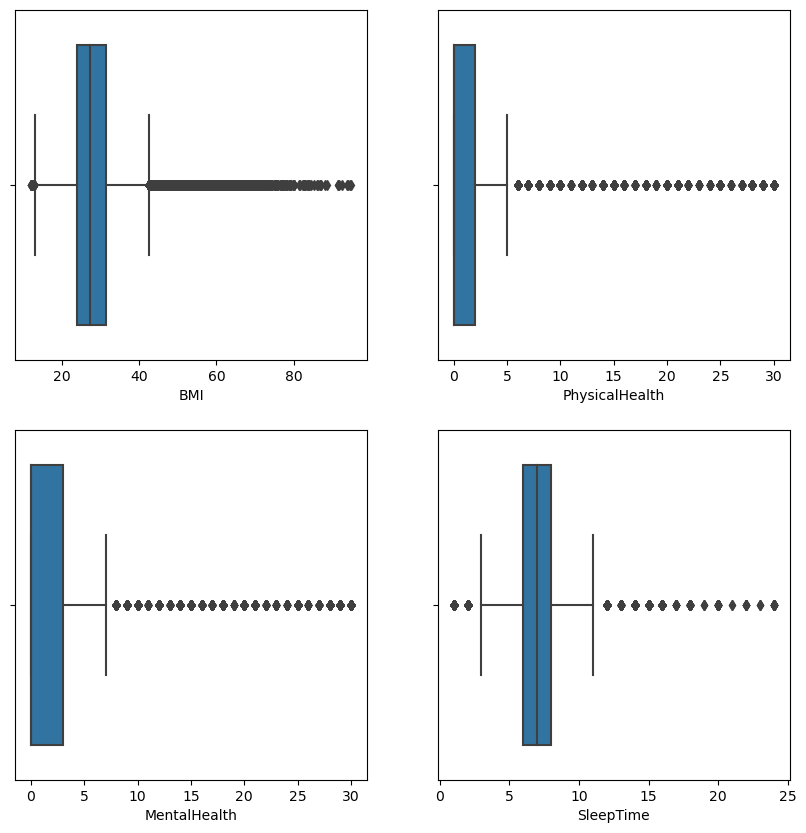

In [9]:
# Checking for potential outliers using boxplot

'''The boxplot displays the distributions of the numerical variables
and highlights potential outliers'''

i = 1
plt.figure(figsize = (10,10))
for column in numerical_predictors:
    plt.subplot(2,2,i)
    sns.boxplot(x = column, data = indicators_df)
    i +=1

In [10]:
#Display Mean and median of numerical predictors

print("Mean of Numerical Attributes:\n",indicators_df[numerical_predictors].mean().T, "\n")
print("Median of Numerical Attributes:\n",indicators_df[numerical_predictors].median().T)

Mean of Numerical Attributes:
 BMI               28.325399
PhysicalHealth     3.371710
MentalHealth       3.898366
SleepTime          7.097075
dtype: float64 

Median of Numerical Attributes:
 BMI               27.34
PhysicalHealth     0.00
MentalHealth       0.00
SleepTime          7.00
dtype: float64


### Observations:

* From the visualization plots, It can be seen that people with heart disease on the average, have lesser sleep, poorer physical health, and their BMI's are slightly higher.
* For each boxplot, the box represents the interquartile range (IQR) of the distributions of each numerical variable. The horizontal line in each box represents the median value and the whiskers extend to the smallest and largest observations within 1.5 times the IQR from the edge of the box. The points (dots) appearing outside this range represent potential outliers.
* It can be seen that all numerical variables contain outliers as they appear to be assymetrical about their means. 
* The boxplots of the 'Sleep' and 'BMI' attributes appear to have similar interquartile range

The outliers will be handled later on in the data preprocessing stage

In [11]:
'''Feature boxplots grouped by Heart Decease are depiced in the figure 
below. Since the orange distribution for BMI and Sleep Time has the 
similar interquartile range, it was decided to delete extreme 
observations in these columns, as a result we are going to lose only 5% 
of information. The deletion was conducted based on the lower and 
upper whiskers of the features box-plots. In case we delete outliers 
in all float columns, we would lose almost 30% of data, which is 
too much lost information.'''

'Feature boxplots grouped by Heart Decease are depiced in the figure \nbelow. Since the orange distribution for BMI and Sleep Time has the \nsimilar interquartile range, it was decided to delete extreme \nobservations in these columns, as a result we are going to lose only 5% \nof information. The deletion was conducted based on the lower and \nupper whiskers of the features box-plots. In case we delete outliers \nin all float columns, we would lose almost 30% of data, which is \ntoo much lost information.'

## Analysis on Categorical Predictors

In [12]:
# Finding the categorical columns in the indicators_df dataframe

categorical_attributes = indicators_df.select_dtypes(include='object').columns
categorical_attributes

Index(['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
       'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity',
       'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

In [13]:
# Creating a List of the categorical predictor attributes for further computing

cat_predictors_list = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
       'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity',
       'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']

#Previewing the categorical predictors from the indicators_df dataframe

indicators_df[cat_predictors_list].head()


Smoking AlcoholDrinking Stroke DiffWalking     Sex  AgeCategory   Race  \
0     Yes              No     No          No  Female        55-59  White   
1      No              No    Yes          No  Female  80 or older  White   
2     Yes              No     No          No    Male        65-69  White   
3      No              No     No          No  Female        75-79  White   
4      No              No     No         Yes  Female        40-44  White   

  Diabetic PhysicalActivity  GenHealth Asthma KidneyDisease SkinCancer  
0      Yes              Yes  Very good    Yes            No        Yes  
1       No              Yes  Very good     No            No         No  
2      Yes              Yes       Fair    Yes            No         No  
3       No               No       Good     No            No        Yes  
4       No              Yes  Very good     No            No         No

In [14]:
indicators_df[cat_predictors_list].describe().T

count unique        top    freq
Smoking           319795      2         No  187887
AlcoholDrinking   319795      2         No  298018
Stroke            319795      2         No  307726
DiffWalking       319795      2         No  275385
Sex               319795      2     Female  167805
AgeCategory       319795     13      65-69   34151
Race              319795      6      White  245212
Diabetic          319795      4         No  269653
PhysicalActivity  319795      2        Yes  247957
GenHealth         319795      5  Very good  113858
Asthma            319795      2         No  276923
KidneyDisease     319795      2         No  308016
SkinCancer        319795      2         No  289976

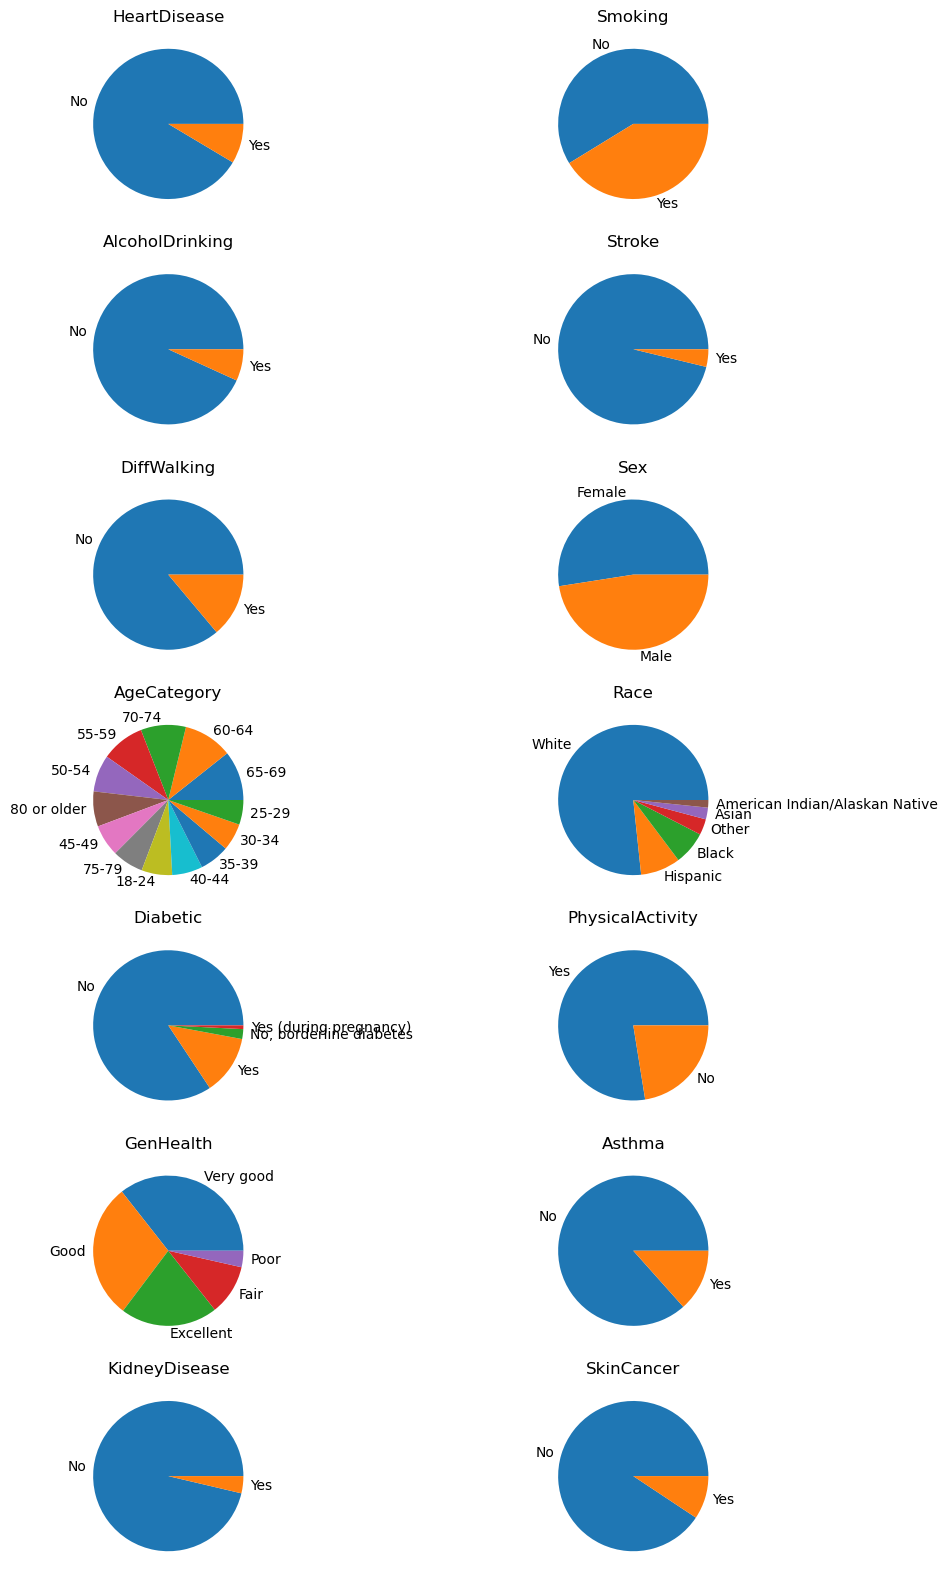

In [15]:
fig,axes = plt.subplots(nrows=7, ncols=2, figsize=(11, 20), dpi=100)

for col, ax in zip(indicators_df[categorical_attributes], axes.ravel()):
    indicators_df[col].value_counts().plot(kind="pie", ax=ax).set_title(col)
    ax.set(ylabel='', title=col, aspect='equal')
plt.show()

In [16]:
def display_plot(predictor, df):
    
    plot = dxp.count(predictor, data = df, split='HeartDisease', normalize=predictor, title = predictor, stacked=True)
    return(plot)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
''' CODE TO DISPLAY ALL CHARTS IN A ROW, use a different plot'''


' CODE TO DISPLAY ALL CHARTS IN A ROW, use a different plot'

In the figures below relative frequencies of Heart disease are depicted for every categorical feature. There are also some observational comments.

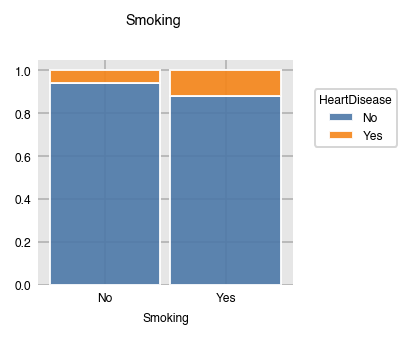

In [18]:
# It seems that smokers are at higher risk of Heart disease than non-smokers 
display_plot(cat_predictors_list[0], indicators_df)

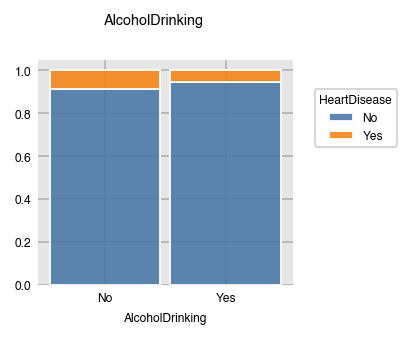

In [19]:
# It is interesting , that heavy alcohol drinkers have smaller relative frequency of Heart disease

display_plot(cat_predictors_list[1],indicators_df)

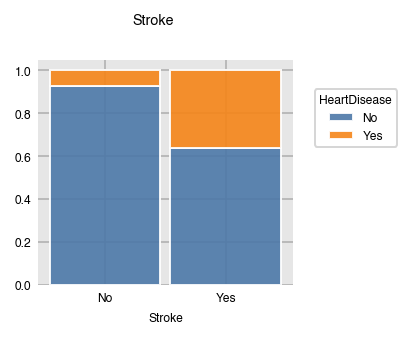

In [20]:
display_plot(cat_predictors_list[2],indicators_df)

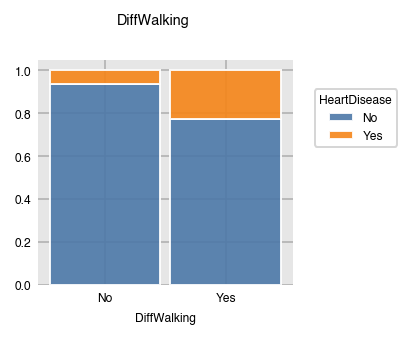

In [21]:
display_plot(cat_predictors_list[3],indicators_df)

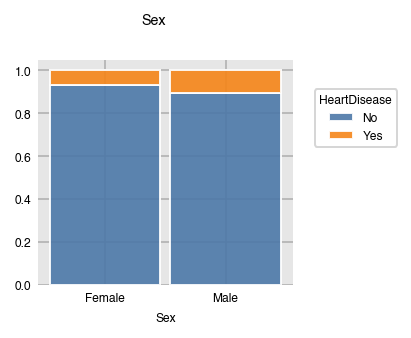

In [22]:
display_plot(cat_predictors_list[4],indicators_df)

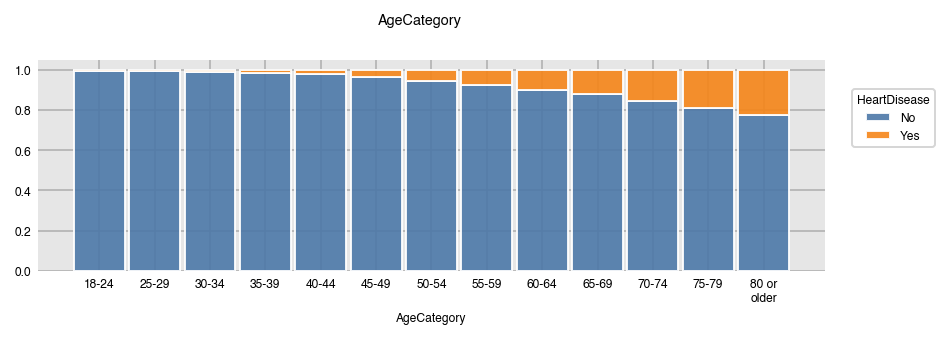

In [23]:
# Older people are more prone to Heart disease

display_plot(cat_predictors_list[5],indicators_df)

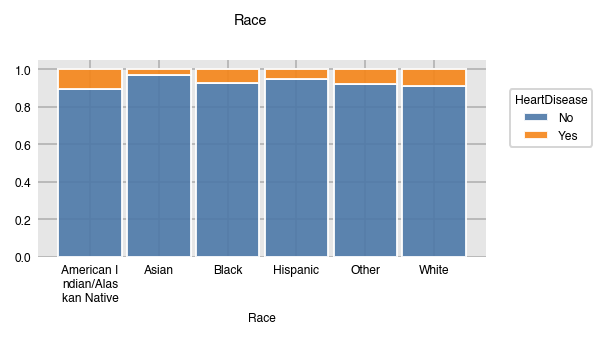

In [24]:
# It is interesting , that asian and hispanic races have the smallest relative frequency of Heart disease

display_plot(cat_predictors_list[6],indicators_df)

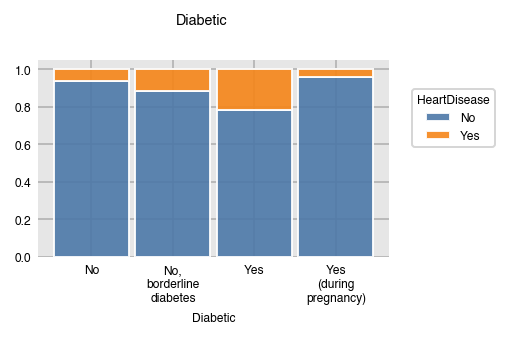

In [25]:
display_plot(cat_predictors_list[7],indicators_df)

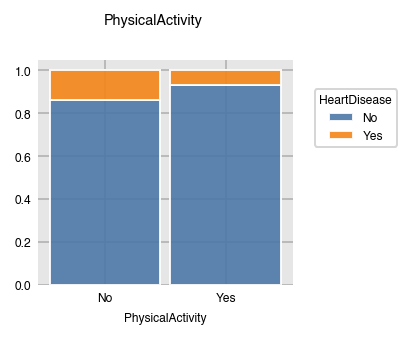

In [26]:
display_plot(cat_predictors_list[8],indicators_df)

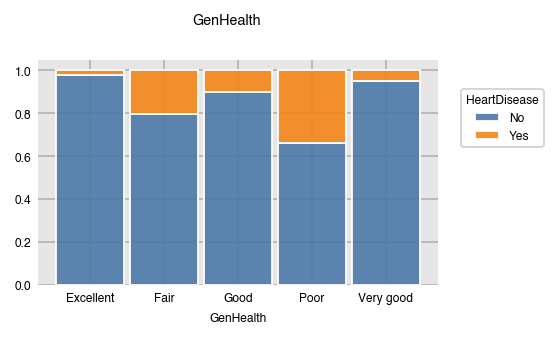

In [27]:
# People with better overall health seem to have smaller relative frequency of Heart disease

display_plot(cat_predictors_list[9],indicators_df)

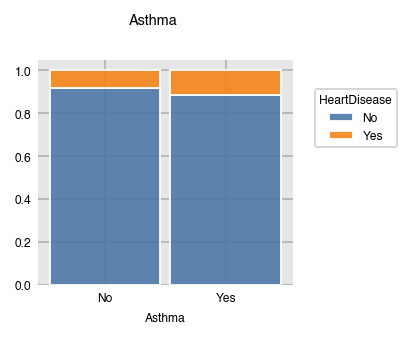

In [28]:
display_plot(cat_predictors_list[10],indicators_df)

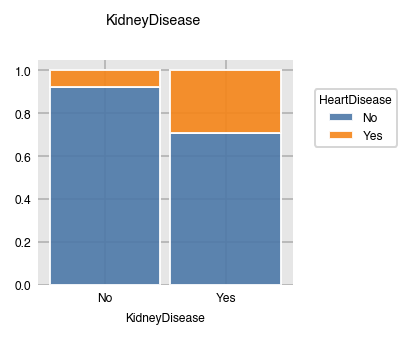

In [29]:
display_plot(cat_predictors_list[11],indicators_df)

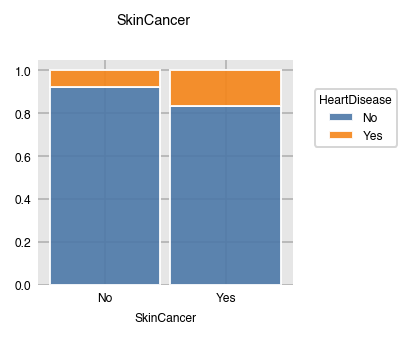

In [30]:
display_plot(cat_predictors_list[12],indicators_df)

### Observations:

* ......
* ......
* .....

# <span style="color:#87CEEB">Data Preprocessing</span>
The dataset was preprocessed based on the exploratory analysis carried out in the previous segments of the code.
I decided to firstly split the data into the training and test sets before applying some preprocessing steps for the following reasons:
* Some preprocessing steps, such as scaling, involve using information about the distribution of the data. If the entire dataset is scaled before splitting, the scaling parameters are learned from the entire dataset, including the test set. This can result in data leakage, where information from the test set is unintentionally incorporated into the training process, leading to overly optimistic evaluation metrics. Hence, the training data is scaled separately and the testing data is also scaled separately but using the same scaling parameters as the training data. This ensures that the input features are in the same range and distribution as the ones the model was trained on.


* Preprocessing steps may introduce biases or artifacts in the data that affect the performance of the model. Applying preprocessing steps separately to the training and testing sets, can ensure that the evaluation metrics are representative of the true performance of the model on unseen data.

The goal is to compare the model performances for the following conditions:
* Initially Unprocessed data
* Oversampled data with outliers (Using SMOTE Oversampling Technique)
* Oversampled data without outliers (SMOTE)
* Oversampled data with outliers (Using ADASYN Oversampling Technique)
* Oversampled without outliers(ADASYN)

Below is my workflow:

1. Sort and encode the categorical attributes.
2. Concatenate the dataframes: Encoded categorical attributes and numerical predictors.
3. Save a copy of the new concatenated dataframe.
4. Remove Outliers from the dataframe copy.
5. Split the dataframes (with and without outliers) to their training and test sets.
5. Apply preprocessing steps of Scaling, and oversampling to the data sets. Oversample the minority class in the training datas alone.
6. Train the models on the respective training sets and evaluate its performance on the testing sets for comparisons.

## Categorical Attributes: Sorting and Encoding


The categorical attributes are sorted into nominal and ordinal variables in order to adequately encode the data for the ML models.

The nominal variables are encoded using the OneHotEncoder.

The ordinal variables are encoded using the OrdinalEncoder.

In [31]:
indicators_df[categorical_attributes].describe().T

count unique        top    freq
HeartDisease      319795      2         No  292422
Smoking           319795      2         No  187887
AlcoholDrinking   319795      2         No  298018
Stroke            319795      2         No  307726
DiffWalking       319795      2         No  275385
Sex               319795      2     Female  167805
AgeCategory       319795     13      65-69   34151
Race              319795      6      White  245212
Diabetic          319795      4         No  269653
PhysicalActivity  319795      2        Yes  247957
GenHealth         319795      5  Very good  113858
Asthma            319795      2         No  276923
KidneyDisease     319795      2         No  308016
SkinCancer        319795      2         No  289976

The next line of code identifies all unique classes in each categorical attribute to guide me in properly sorting them into nominal and ordinal variables.

In [32]:
# Identifying all unique classes in each categorical attribute

cat_attr_list = list(indicators_df[categorical_attributes])
for i in cat_attr_list:
    print(i)
    print(indicators_df[i].unique())

HeartDisease
['No' 'Yes']
Smoking
['Yes' 'No']
AlcoholDrinking
['No' 'Yes']
Stroke
['No' 'Yes']
DiffWalking
['No' 'Yes']
Sex
['Female' 'Male']
AgeCategory
['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64' '50-54'
 '45-49' '18-24' '35-39' '30-34' '25-29']
Race
['White' 'Black' 'Asian' 'American Indian/Alaskan Native' 'Other'
 'Hispanic']
Diabetic
['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)']
PhysicalActivity
['Yes' 'No']
GenHealth
['Very good' 'Fair' 'Good' 'Poor' 'Excellent']
Asthma
['Yes' 'No']
KidneyDisease
['No' 'Yes']
SkinCancer
['Yes' 'No']


### Observations and Actions:

There is no inherent order between 'Yes' and 'No' therefore all 9 variables with only both aforementioned classes are considered binary nominal variables.

The 'Sex' variable is also considered a binary nominal variable as there is no inherent order between 'Female' and 'Male'.

The 'Race' variable is also considered a nominal variable as there is no inherent order between races.

The 'AgeCategory' variable is a multi-level variable with 13 levels. I have observed that the widths of each age range are not entirely uniform ('80 or older'), hence the assumption of equidistance may not hold and so this may be treated as a nominal variable. However, being that all levels represent ordered ranges of age, it will be treated as an ordinal variable, also because encoding it using one-hot encoding would require the introduction of 12 more binary columns to the data and this can increase the complexity of the model and the risk of overfitting.

The 'Diabetic' variable is a multi-level variable with 4 levels. The levels of this variable do not suggest a clear order or ranking, as 'Yes' does not necessarily indicate a higher or lower value than 'Yes (during pregnancy)', 'No' or 'No, borderline diabetes'. Therefore, this variable was considered nominal.

The 'GenHealth' variable is a multi-level variable with 5 levels. These levels do suggest an order or ranking, where 'Very good' is better than 'Fair', which is better than 'Poor', etc. Therefore, this variable was considered ordinal.

This leaves me with: 
* 12 nominal variables; 10 binary and 2 non-binary variables ("Race", "Diabetic")
* 2 ordinal variables ('AgeCategory' and 'GenHealth')



#### Next I group the categorical attributes into nominal and ordinal variables

In [33]:
# Create a list of all binary variables
binary_var_list= list()
for i in cat_attr_list:
    if indicators_df[i].nunique()<3:
        binary_var_list.append(i)

# Create a list of all non-binary variables
nonbinary_var_list= list()
for i in cat_attr_list:
    if indicators_df[i].nunique()>2:
        nonbinary_var_list.append(i)

print("Binary Variables below:\n", binary_var_list, "\n\nTotal:", len(binary_var_list), "\n")
print("Non-Binary Variables below:\n", nonbinary_var_list, "\n\nTotal:", len(nonbinary_var_list), "\n")

Binary Variables below:
 ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer'] 

Total: 10 

Non-Binary Variables below:
 ['AgeCategory', 'Race', 'Diabetic', 'GenHealth'] 

Total: 4 



In [34]:
# Create a list of Nominal variables
nominal_var_list= binary_var_list + ["Race", "Diabetic"]


# Create a list of ordinal variables
ordinal_var_list = [var for var in nonbinary_var_list if var not in ['Race', 'Diabetic']]



print("Nominal Variables below:\n", nominal_var_list, "\n\nTotal:", len(nominal_var_list), "\n")
print("Ordinal Variables below:\n", ordinal_var_list, "\n\nTotal:", len(ordinal_var_list), "\n")

Nominal Variables below:
 ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'Race', 'Diabetic'] 

Total: 12 

Ordinal Variables below:
 ['AgeCategory', 'GenHealth'] 

Total: 2 



#### Encoding The Nominal Variables

In [35]:
# Encoding the nominal variables using OneHotEncoder

# fit the encoder to the data
onehot_encoder = OneHotEncoder(drop='if_binary').fit(indicators_df[nominal_var_list])

# transform the nominal variables into binary variables
indicators_df_encoded = onehot_encoder.fit_transform(indicators_df[nominal_var_list]).toarray()

# create a new dataframe using encoded variables
indicators_df_onehot = pd.DataFrame(indicators_df_encoded, columns=onehot_encoder.get_feature_names_out(nominal_var_list))

# print the new dataframe
indicators_df_onehot

HeartDisease_Yes  Smoking_Yes  AlcoholDrinking_Yes  Stroke_Yes  \
0                    0.0          1.0                  0.0         0.0   
1                    0.0          0.0                  0.0         1.0   
2                    0.0          1.0                  0.0         0.0   
3                    0.0          0.0                  0.0         0.0   
4                    0.0          0.0                  0.0         0.0   
...                  ...          ...                  ...         ...   
319790               1.0          1.0                  0.0         0.0   
319791               0.0          1.0                  0.0         0.0   
319792               0.0          0.0                  0.0         0.0   
319793               0.0          0.0                  0.0         0.0   
319794               0.0          0.0                  0.0         0.0   

        DiffWalking_Yes  Sex_Male  PhysicalActivity_Yes  Asthma_Yes  \
0                   0.0       0.0                   1.0         1.0   
1                   0.0       0.0                   1.0         0.0   
2                   0.0       1.0                   1.0         1.0   
3                   0.0       0.0                   0.0         0.0   
4                   1.0       0.0                   1.0         0.0   
...                 ...       ...                   ...         ...   
319790              1.0       1.0                   0.0         1.0   
319791              0.0       1.0                   1.0         1.0   
319792              0.0       0.0                   1.0         0.0   
319793              0.0       0.0                   0.0         0.0   
319794              0.0       0.0                   1.0         0.0   

        KidneyDisease_Yes  SkinCancer_Yes  \
0                     0.0             1.0   
1                     0.0             0.0   
2                     0.0             0.0   
3                     0.0             1.0   
4                     0.0             0.0   
...                   ...             ...   
319790                0.0             0.0   
319791                0.0             0.0   
319792                0.0             0.0   
319793                0.0             0.0   
319794                0.0             0.0   

        Race_American Indian/Alaskan Native  Race_Asian  Race_Black  \
0                                       0.0         0.0         0.0   
1                                       0.0         0.0         0.0   
2                                       0.0         0.0         0.0   
3                                       0.0         0.0         0.0   
4                                       0.0         0.0         0.0   
...                                     ...         ...         ...   
319790                                  0.0         0.0         0.0   
319791                                  0.0         0.0         0.0   
319792                                  0.0         0.0         0.0   
319793                                  0.0         0.0         0.0   
319794                                  0.0         0.0         0.0   

        Race_Hispanic  Race_Other  Race_White  Diabetic_No  \
0                 0.0         0.0         1.0          0.0   
1                 0.0         0.0         1.0          1.0   
2                 0.0         0.0         1.0          0.0   
3                 0.0         0.0         1.0          1.0   
4                 0.0         0.0         1.0          1.0   
...               ...         ...         ...          ...   
319790            1.0         0.0         0.0          0.0   
319791            1.0         0.0         0.0          1.0   
319792            1.0         0.0         0.0          1.0   
319793            1.0         0.0         0.0          1.0   
319794            1.0         0.0         0.0          1.0   

        Diabetic_No, borderline diabetes  Diabetic_Yes  \
0                                    0.0           1.0   
1          

#### Encoding the Ordinal Variables

In [36]:
# encode ordinal variables using OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
indicators_df_encoded1 = ordinal_encoder.fit_transform(indicators_df[ordinal_var_list])

# create a new dataframe with both original and encoded ordinal variables for comparison
ordinal_var_list_encoded = [var+'_encoded' for var in ordinal_var_list]
indicators_df_ordinal = pd.concat([indicators_df[ordinal_var_list], pd.DataFrame(indicators_df_encoded1, columns=ordinal_var_list_encoded)], axis=1)

# print the new dataframe
indicators_df_ordinal


AgeCategory  GenHealth  AgeCategory_encoded  GenHealth_encoded
0             55-59  Very good                  7.0                4.0
1       80 or older  Very good                 12.0                4.0
2             65-69       Fair                  9.0                1.0
3             75-79       Good                 11.0                2.0
4             40-44  Very good                  4.0                4.0
...             ...        ...                  ...                ...
319790        60-64       Fair                  8.0                1.0
319791        35-39  Very good                  3.0                4.0
319792        45-49       Good                  5.0                2.0
319793        25-29       Good                  1.0                2.0
319794  80 or older       Good                 12.0                2.0

[319795 rows x 4 columns]

In [37]:
# Compare the original and encoded ordinal variables
check_list = list(indicators_df_ordinal)
for i in check_list:
    print(i)
    print(indicators_df_ordinal[i].unique())

AgeCategory
['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64' '50-54'
 '45-49' '18-24' '35-39' '30-34' '25-29']
GenHealth
['Very good' 'Fair' 'Good' 'Poor' 'Excellent']
AgeCategory_encoded
[ 7. 12.  9. 11.  4. 10.  8.  6.  5.  0.  3.  2.  1.]
GenHealth_encoded
[4. 1. 2. 3. 0.]


From a close observation, it appears that 'GenHealth' was not encoded accurately (0 = Excellent, 1 = Fair, 2 = Good, 3 = poor, 4 = Very Good). The encoded variables need to be remapped correctly and in the following order: 'Excellent' = 0, 'Very good' = 1, 'Good' = 2, 'Fair' = 3, and 'Poor' = 4. This way, the encoded values will be more intuitive and easier to interpret.

In [38]:
# Define a dictionary for mapping
genhealth_map = {
    'Excellent': 0,
    'Very good': 1,
    'Good': 2,
    'Fair': 3,
    'Poor': 4
}

# Apply the mapping to the 'GenHealth' column
indicators_df_ordinal['GenHealth_encoded'] = indicators_df_ordinal['GenHealth'].map(genhealth_map)

# Print the new dataframe
indicators_df_ordinal


AgeCategory  GenHealth  AgeCategory_encoded  GenHealth_encoded
0             55-59  Very good                  7.0                  1
1       80 or older  Very good                 12.0                  1
2             65-69       Fair                  9.0                  3
3             75-79       Good                 11.0                  2
4             40-44  Very good                  4.0                  1
...             ...        ...                  ...                ...
319790        60-64       Fair                  8.0                  3
319791        35-39  Very good                  3.0                  1
319792        45-49       Good                  5.0                  2
319793        25-29       Good                  1.0                  2
319794  80 or older       Good                 12.0                  2

[319795 rows x 4 columns]

Now I drop the original ordinal variables from the indicators_df_ordinal dataframe, leaving only the encoded.

In [39]:
indicators_df_ordinal = indicators_df_ordinal.drop(['AgeCategory', 'GenHealth'], axis=1)
indicators_df_ordinal

AgeCategory_encoded  GenHealth_encoded
0                       7.0                  1
1                      12.0                  1
2                       9.0                  3
3                      11.0                  2
4                       4.0                  1
...                     ...                ...
319790                  8.0                  3
319791                  3.0                  1
319792                  5.0                  2
319793                  1.0                  2
319794                 12.0                  2

[319795 rows x 2 columns]

## Concatenating Encoded dataframes and Numerical predictors

Create a new dataframe that concatenates the numerical predictors dataframe and all encoded dataframes.

In [40]:
indicators_df_num = indicators_df[numerical_predictors]

In [41]:
# concatenate the dataframes
concat_df = pd.concat([indicators_df_num, indicators_df_onehot, indicators_df_ordinal], axis=1)

# print info on the concatenated dataframe
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 26 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   BMI                                  319795 non-null  float64
 1   PhysicalHealth                       319795 non-null  float64
 2   MentalHealth                         319795 non-null  float64
 3   SleepTime                            319795 non-null  float64
 4   HeartDisease_Yes                     319795 non-null  float64
 5   Smoking_Yes                          319795 non-null  float64
 6   AlcoholDrinking_Yes                  319795 non-null  float64
 7   Stroke_Yes                           319795 non-null  float64
 8   DiffWalking_Yes                      319795 non-null  float64
 9   Sex_Male                             319795 non-null  float64
 10  PhysicalActivity_Yes                 319795 non-null  float64
 11  Asthma_Yes   

The new cleaned and encoded dataframe conists 26 attributes and memory usage of 60.5 MB compared to 43.9 MB of the original dataframe

## Creating a Dataframe from the Concatenated dataframe without Outliers 

In [42]:
# Create a copy of the dataframe
concat_df_copy = concat_df.copy()

#### Numerical Predictors: Dealing with Outliers

Recall: from the boxplots that the distributions of the numerical predictors are assymetrical about their mean values. The horizontal line in each box of the numerical predictor box plots represents the median value and the whiskers extend to the smallest and largest observations within 1.5 times the IQR from the edge of the box. The points (dots) appearing outside this range represent potential outliers.

To deal with the outliers in the skewed columns I will be applying:
* Trimming / IQR Method: Removing extreme outliers beyond the whisker of the some of the box plots of the numerical predictors.
* Logarithmic transformation and square root transformation to further reduce the skew of the PhysicalHealth and MentalHealth features.

#### Analysing the Outliers in the dataframe Copy

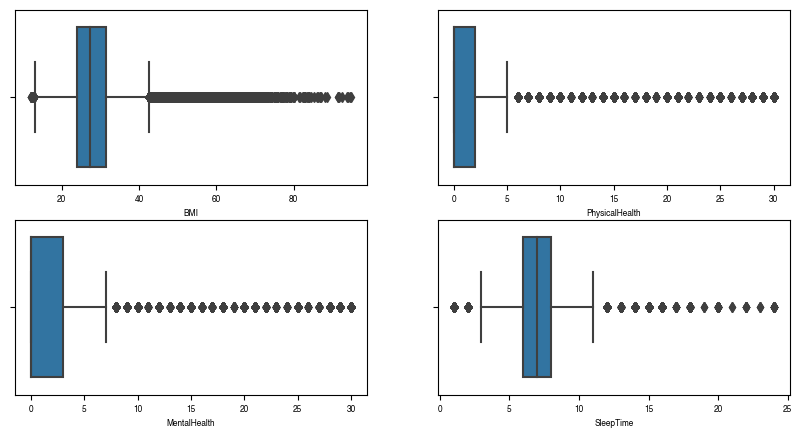

In [251]:
# Box plots showing potential outliers before applying IQR method

i = 1
plt.figure(figsize = (10,5))
for column in numerical_predictors:
    plt.subplot(2,2,i)
    sns.boxplot(x = column, data = concat_df_copy)
    i +=1

The cell below defines a function to quantify the extent to which the numerical predictors are skewed

In [44]:
def skewness(df, skewness_limit=0.75):
    
    # Calculate the skewness of the numerical predictors in the given df
    skewness_values = df.skew()
    
    # Sort the skewness values in descending order
    # Convert them to a dataframe, and rename the column to 'SkewnessLevel'
    # Keep only the columns where the absolute skewness value is greater than the skewness limit defined earlier
    global skewed_columns
    skewed_columns = (skewness_values
                 .sort_values(ascending=False)
                 .to_frame()
                 .rename(columns={0:'Skewness'})
                 .query('abs(Skewness) > {}'.format(skewness_limit)))
    
    # Print the resulting dataframe with the columns sorted by decreasing absolute skewness value
    print(skewed_columns)

In [45]:
# Check Skewness of numerical predictors
skewness(concat_df_copy[numerical_predictors])

                Skewness
PhysicalHealth  2.603973
MentalHealth    2.331112
BMI             1.332431


In [46]:
concat_df_copy.columns

Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime',
       'HeartDisease_Yes', 'Smoking_Yes', 'AlcoholDrinking_Yes', 'Stroke_Yes',
       'DiffWalking_Yes', 'Sex_Male', 'PhysicalActivity_Yes', 'Asthma_Yes',
       'KidneyDisease_Yes', 'SkinCancer_Yes',
       'Race_American Indian/Alaskan Native', 'Race_Asian', 'Race_Black',
       'Race_Hispanic', 'Race_Other', 'Race_White', 'Diabetic_No',
       'Diabetic_No, borderline diabetes', 'Diabetic_Yes',
       'Diabetic_Yes (during pregnancy)', 'AgeCategory_encoded',
       'GenHealth_encoded'],
      dtype='object')

###### Observations and Actions:

From the box plots and the skewness levels, it appears that 'PhysicalHealth' and 'MentalHealth' are largely skewed and are the most skew numerical predictors, hence caution must be taken in dealing with their outliers so that too much data is not lost in the process.

'BMI' and 'SleepTime' distributions appear to have similar IQR and are far less skewed compared to 'PhysicalHealth' and 'MentalHealth'. 

About 71% of the 'PhysicalHealth' values and 65% of the 'MentalHealth' values are 0s (from a range of 0 to 30 indicating number of sick days within the last 30 days). This suggests that a large proportion of the individuals did not report any physical or mental health issues. Removing outliers from these variables, would likely result in a huge loss of information or a biased sample, as all the individuals who did report physical or mental health issues may be important for predicting heart disease. (I attempted this using the IQR method to remove all extreme outliers beyond the whiskers of all boxes of the all numerical variables (including 'PhysicalHealth' and 'MentalHealth') and this resulted in about 28% loss of the data in the training data. This was too much).

Also no outliers in the concerned variables are of extreme values above 30 days. Hence, all recorded values are representative of the typical or expected values reported by the individuals (0 to 30 days). Based on these reasons, I decided not to apply the IQR method in removing outliers in both variables. Instead I applied a combination of Logarithmic transformation and square root transformation to further reduce the skewness in these variables without trimming the dataset further.

I decided to apply the IQR method only to the 'BMI' and 'SleepTime' columns as they were less skewed. Only about 5% data was lost this time.

#### Removing outliers from the Dataframe Copy
The code below computes the upper and lower whiskers of the box plots for each of the numerical predictors in the 'concat_df_copy' dataframe.

In [47]:
# Define an empty DataFrame to store the whiskers
whiskers = pd.DataFrame(columns=['LowerW', 'UpperW'])

# Iterate over the numerical columns
for col in numerical_predictors:
    
    # Calculate the median and quartiles
    median = np.median(concat_df_copy[col])
    q25 = np.percentile(concat_df_copy[col], 25)
    q75 = np.percentile(concat_df_copy[col], 75)

    # Calculate the interquartile range
    iqr = q75 - q25

    # Calculate the upper and lower whiskers
    upper_whisker = concat_df_copy[col][concat_df_copy[col] <= q75 + 1.5 * iqr].max()
    lower_whisker = concat_df_copy[col][concat_df_copy[col] >= q25 - 1.5 * iqr].min()

    # Add the whiskers to the DataFrame
    whiskers.loc[col] = [lower_whisker, upper_whisker]

whiskers

LowerW  UpperW
BMI              12.97    42.5
PhysicalHealth    0.00     5.0
MentalHealth      0.00     7.0
SleepTime         3.00    11.0

Next, I filter the dataframe to keep only the instances where the values of the 'BMI' and 'SleepTime' predictors are within the whiskers of their respective box plots, and then compute summary statistics for the remaining rows of the train data.

In [48]:
numerical_predictors

Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime'], dtype='object')

In [49]:
# Define a function to filter outliers
def filter_outliers(df, col, lower, upper):
    return df[(df[col] >= lower) & (df[col] <= upper)]

# Filter the outliers using the whiskers
bmi_lower, bmi_upper = whiskers.loc['BMI', 'LowerW'], whiskers.loc['BMI', 'UpperW']
#physical_lower, physical_upper = whiskers_train.loc['PhysicalHealth', 'LowerW'], whiskers_train.loc['PhysicalHealth', 'UpperW']
#mental_lower, mental_upper = whiskers_train.loc['MentalHealth', 'LowerW'], whiskers_train.loc['MentalHealth', 'UpperW']
sleep_lower, sleep_upper = whiskers.loc['SleepTime', 'LowerW'], whiskers.loc['SleepTime', 'UpperW']

# Remove the filters from 
concat_df_iqr = filter_outliers(concat_df_copy, 'BMI', bmi_lower, bmi_upper)
#train_copy_iqr = filter_outliers(train_copy_iqr, 'PhysicalHealth', physical_lower, physical_upper)
#train_copy_iqr = filter_outliers(train_copy_iqr, 'MentalHealth', mental_lower, mental_upper)
concat_df_iqr = filter_outliers(concat_df_iqr, 'SleepTime', sleep_lower, sleep_upper)


# Reset the index and compute the summary statistics for the numerical columns
concat_df_iqr = concat_df_iqr.reset_index()
concat_df_iqr = concat_df_iqr.drop('index', axis=1)
concat_df_iqr[numerical_predictors].describe().T


count       mean       std    min    25%    50%   75%   max
BMI             305113.0  27.664319  5.209102  12.97  23.81  27.12  30.9  42.5
PhysicalHealth  305113.0   3.165129  7.692373   0.00   0.00   0.00   1.0  30.0
MentalHealth    305113.0   3.747651  7.781831   0.00   0.00   0.00   3.0  30.0
SleepTime       305113.0   7.068489  1.229315   3.00   6.00   7.00   8.0  11.0

In [50]:
# Checking the amount of data that was lost after removing outliers

# Calculate the percentage of data loss after removing outliers
percent_data_loss = (len(concat_df_iqr) - len(concat_df_copy)) / len(concat_df_copy) * 100

print("Percentage of Data Loss after removing outliers: {:.2f}%".format(percent_data_loss))


Percentage of Data Loss after removing outliers: -4.59%


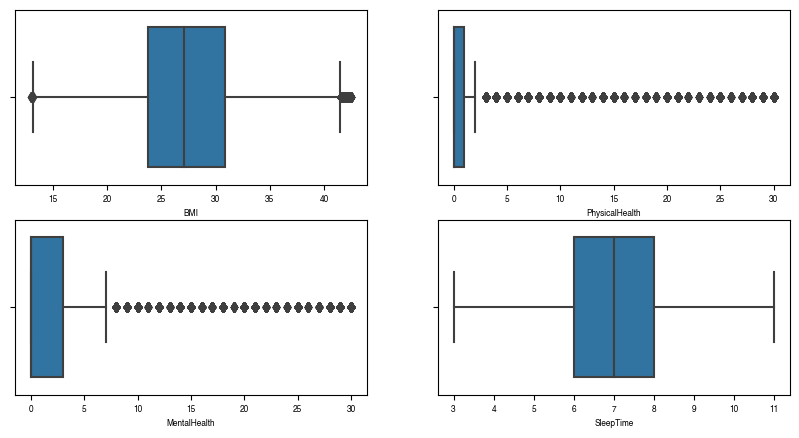

In [252]:
# Box plots visualizations after applying IQR method
i = 1
plt.figure(figsize = (10,5))
for column in numerical_predictors:
    plt.subplot(2,2,i)
    sns.boxplot(x = column, data = concat_df_iqr)
    i +=1


In [52]:
#Checking the skewness after applying IQR method
skewness(concat_df_iqr[numerical_predictors])

                Skewness
PhysicalHealth  2.728974
MentalHealth    2.404157


Next, I attempt to make the numerical variables more normally distributed by applying logarithmic transformation to the columns as it appears that 'PhysicalHealth' and 'MentalHealth' are still largely skewed

In [53]:
# Create a copy of the iqr dataframe
concat_df_log = concat_df_iqr.copy()

# Select the columns to be transformed
cols_to_transform = skewed_columns.index.values

# Apply logarithmic transformation
concat_df_log[cols_to_transform] = concat_df_iqr[cols_to_transform].apply(np.log1p)


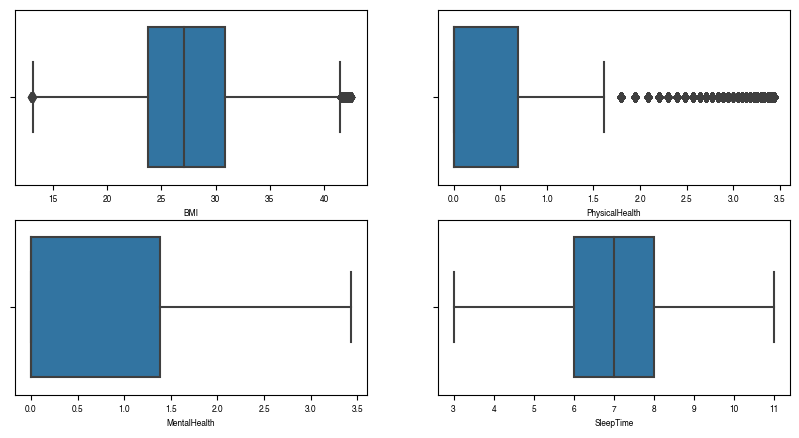

In [253]:
# Box plots visualizations after applying logarithmic transformation
i = 1
plt.figure(figsize = (10,5))
for column in numerical_predictors:
    plt.subplot(2,2,i)
    sns.boxplot(x = column, data = concat_df_log)
    i +=1

In [55]:
#Checking the skewness after applying logarithmic transformation
skewness(concat_df_log[numerical_predictors])

                Skewness
PhysicalHealth  1.664062
MentalHealth    1.238801


It can be observed that 'PhysicalHealth' and 'MentalHealth' are less skewed compared to the previous step. 'PhysicalHealth' is still largely skewed when compared to 'MentalHealth'. The Square root transformation is applied to the data to further reduce the influence of the outliers and to make the numerical predictors have a more normal distribution for a better model performance 

In [56]:
# Create a copy of the log dataframe
concat_df_sqrt = concat_df_log.copy()

# Applying the square root transformation
concat_df_sqrt[cols_to_transform] = np.sqrt(concat_df_log[cols_to_transform])


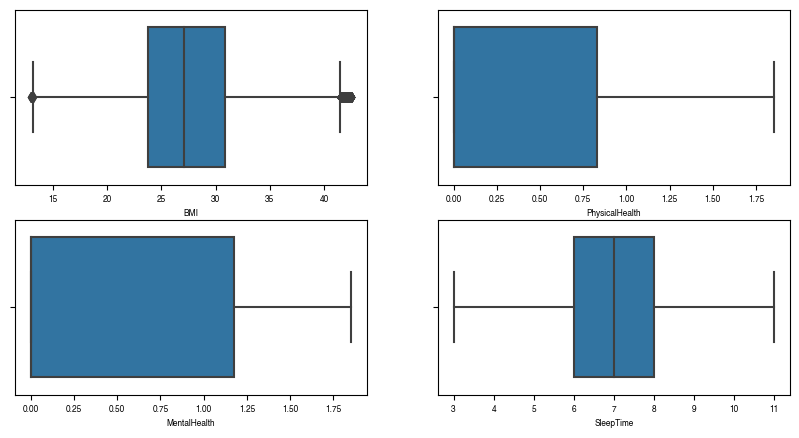

In [254]:
# Box plots visualizations after applying Square root transformation
i = 1
plt.figure(figsize = (10,5))
for column in numerical_predictors:
    plt.subplot(2,2,i)
    sns.boxplot(x = column, data = concat_df_sqrt)
    i +=1

In [58]:
#Checking the skewness after applying Square root transformation
skewness(concat_df_sqrt[numerical_predictors])

                Skewness
PhysicalHealth  1.219073
MentalHealth    0.837240


Physical and Mental Health are far less skewed now and all numerical predicators are closer to normal ditribution.

In [59]:
concat_df_sqrt.columns

Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime',
       'HeartDisease_Yes', 'Smoking_Yes', 'AlcoholDrinking_Yes', 'Stroke_Yes',
       'DiffWalking_Yes', 'Sex_Male', 'PhysicalActivity_Yes', 'Asthma_Yes',
       'KidneyDisease_Yes', 'SkinCancer_Yes',
       'Race_American Indian/Alaskan Native', 'Race_Asian', 'Race_Black',
       'Race_Hispanic', 'Race_Other', 'Race_White', 'Diabetic_No',
       'Diabetic_No, borderline diabetes', 'Diabetic_Yes',
       'Diabetic_Yes (during pregnancy)', 'AgeCategory_encoded',
       'GenHealth_encoded'],
      dtype='object')

In [60]:
# Dataframe without outliers
df_no_out = concat_df_sqrt
df_no_out.shape

(305113, 26)

In [61]:
# Dataframe with outliers
df_out = concat_df
df_out.shape

(319795, 26)

## Splitting Dataframes into Training and Test sets

In [62]:
# Define function to split the dataframes
def split_func(df):
    X = df.drop(['HeartDisease_Yes'], axis=1)
    y = df['HeartDisease_Yes']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=50)
    return X_train, X_test, y_train, y_test

In [63]:
# Sets with outliers
X_train_o, X_test_o, Y_train_o, Y_test_o = split_func(df_out)

# Sets without outliers
X_train_no, X_test_no, Y_train_no, Y_test_no = split_func(df_no_out)


In [64]:
# Check if the indices are equal
print(X_train_o.index.equals(Y_train_o.index))
print(X_test_o.index.equals(Y_test_o.index))

print(X_train_no.index.equals(Y_train_no.index))
print(X_test_no.index.equals(Y_test_no.index))

True
True
True
True


I proceed to standardize the training data because some of the models to be fitted on the data can be sensitive to the scale of input features.


#### Scaling the Train and Test data with/without outliers
I decided to scale the train and test data and data sets before oversampling as oversampling techniques can introduce new data points that may not have the same scale as the original data. Therefore, scaling the data before oversampling can ensure that the new data points created during oversampling are consistent with the original data.
Firstly, split the Train and Test data copies back to their X and Y variants.

In [65]:
def scale_func(X, x):
    # Initialize a StandardScaler object
    scaler = StandardScaler()

    # Fit the scaler on the training set and transform it
    X_scaled = scaler.fit_transform(X)
    #X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    
    # Transform the test set using the fitted scaler
    x_scaled = scaler.transform(x)
    #X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    
    X = X_scaled
    x = x_scaled
    
    return X, x


In [66]:
# Scale the train sets
X_train_o, X_test_o = scale_func(X_train_o, X_test_o)
X_train_no, X_test_no = scale_func(X_train_no, X_test_no)

#### Dealing With Class Imbalance in the Response Variable
Based on the extremely high difference between both classes, undersampling the majority class will result in too much data loss and so the technique was not adopted. I decided to adopt 2 oversampling techniques to balance the class distribution in the dataset and ensure that the model has enough data to learn from both classes.

The following techniques were considered and compared:
* SMOTE (Synthetic Minority Over-sampling Technique): An oversampling technique that generates synthetic samples for the minority class by interpolating between existing minority samples. Specifically, for each minority sample, SMOTE selects k nearest neighbors and generates new samples by linearly interpolating between the original sample and one of its neighbors. However, it may generate noisy samples that could adversely affect the performance of the model

* ADASYN (Adaptive Synthetic Sampling) Technique: This is a variant of the SMOTE algorithm. It generates synthetic samples in a way that is adapted to the local density of the minority class. Specifically, ADASYN generates more synthetic samples for minority samples that are harder to learn by the model, i.e., those that are in regions where the density of the minority class is low. This is done by first computing the density of minority samples in the dataset, and then generating synthetic samples based on the inverse of the density. This results in more synthetic samples being generated in regions where the minority class is under-represented, which can improve the performance of the model.

Oversampling was done on the training data alone, to ensure that the model sees enough examples of the minority class. The test data is kept separate and not manipulated, so that the performance of the model can be accurately assessed on unseen data.

### Oversampling using SMOTE Technique

I proceed to find the optimal value of `n_neighbors` for the SMOTE's k-nearest neighbors and apply this to the SMOTE algorithm

In [67]:
# Define the function
def find_optimal_k(X, Y):
    """
    This function takes in X and Y as arguments, 
    performs a grid search to find the optimal value of k for KNN, 
    and returns the best parameter and score.
    """
    # Define the hyperparameter grid
    param_grid = {'n_neighbors': [50, 55, 60, 65]}

    # Create a k-nearest neighbors classifier
    knn = KNeighborsClassifier()

    # Use grid search to find the optimal value of k
    grid_search = GridSearchCV(knn, param_grid, cv=5)
    grid_search.fit(X, Y)

    # Print the best parameter and score
    print(f"Best parameter: {grid_search.best_params_}")
    print(f"Best score: {round(grid_search.best_score_, 2)}")

In [68]:
%%time

print("Optimal K: Outliers:","\n",find_optimal_k(X_train_o, Y_train_o))
print("\nOptimal K: No Outliers:",find_optimal_k(X_train_no, Y_train_no))

Best parameter: {'n_neighbors': 60}
Best score: 0.92
Optimal K: Outliers: 
 None
Best parameter: {'n_neighbors': 55}
Best score: 0.92

Optimal K: No Outliers: None
CPU times: user 1h 25min 36s, sys: 26.3 s, total: 1h 26min 2s
Wall time: 25min 19s


In [69]:
# Oversampling the training data using SMOTE
# Function to oversample using SMOTE
def smote_oversample(X, Y, n):
    oversample = SMOTE(k_neighbors=n, random_state=50)
    X_smoted, Y_smoted = oversample.fit_resample(X, Y)

    print(f'No. of records before using SMOTE\n{Y.value_counts()}\n')
    print(f'No. of records after using SMOTE\n{Y_smoted.value_counts()}')
    
    return X_smoted, Y_smoted


In [70]:
X_train_o_smt, Y_train_o_smt = smote_oversample(X_train_o, Y_train_o, 60)

No. of records before using SMOTE
0.0    233938
1.0     21898
Name: HeartDisease_Yes, dtype: int64

No. of records after using SMOTE
1.0    233938
0.0    233938
Name: HeartDisease_Yes, dtype: int64


In [71]:
X_train_no_smt, Y_train_no_smt = smote_oversample(X_train_no, Y_train_no, 55)

No. of records before using SMOTE
0.0    223715
1.0     20375
Name: HeartDisease_Yes, dtype: int64

No. of records after using SMOTE
0.0    223715
1.0    223715
Name: HeartDisease_Yes, dtype: int64


### Oversampling using ADASYN Technique

In [72]:
# Oversampling the train data using ADASYN
# Function to oversample using ADASYN
def adasyn_oversample (X, Y):
    oversample_ads = ADASYN(random_state=50)
    X_ads, Y_ads = oversample_ads.fit_resample(X, Y)
    
    print(f'No. of records before using ADASYN\n{Y.value_counts()}\n')
    print(f'No. of records after using ADASYN\n{Y_ads.value_counts()}')
    
    return X_ads, Y_ads

In [73]:
X_train_o_ads, Y_train_o_ads = adasyn_oversample(X_train_o, Y_train_o)

No. of records before using ADASYN
0.0    233938
1.0     21898
Name: HeartDisease_Yes, dtype: int64

No. of records after using ADASYN
1.0    238668
0.0    233938
Name: HeartDisease_Yes, dtype: int64


In [74]:
X_train_no_ads, Y_train_no_ads = adasyn_oversample(X_train_no, Y_train_no)

No. of records before using ADASYN
0.0    223715
1.0     20375
Name: HeartDisease_Yes, dtype: int64

No. of records after using ADASYN
0.0    223715
1.0    222645
Name: HeartDisease_Yes, dtype: int64


# <span style="color:#87CEEB"> Models: Design and Evaluation</span>

In [256]:
clf = list()
sample = list()
accuracy = list()
precision = list()
recall = list()
F1score = list()
AUCROC = list()

def eval_on_test(model, X_test, Y_test, algo=None, sampling=None):
    
    # Test set prediction
    Y_prob=model.predict_proba(X_test)
    Y_pred=model.predict(X_test)

    print('Confusion Matrix')
    print('='*70)
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    TN, FP, FN, TP = cm.ravel()
    print("TN={0}, FP={1}, FN={2}, TP={3}".format(TN, FP,FN, TP))
    disp =metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print("\n")
    print('Classification Report')
    print('='*70)
    print(classification_report(Y_test,Y_pred),"\n")
    print('AUC-ROC')
    print('='*70)
    print(roc_auc_score(Y_test, Y_prob[:,1]))
          
    clf.append(algo)
    accuracy.append(accuracy_score(Y_test, Y_pred))
    precision.append(precision_score(Y_test,Y_pred))
    recall.append(recall_score(Y_test,Y_pred))
    F1score.append(f1_score(Y_test,Y_pred))
    AUCROC.append(roc_auc_score(Y_test, Y_prob[:,1]))
    sample.append(sampling)

## LightGBM Model

#### Inital Data : With Outliers and No Sampling

In [257]:
%%time
# Fit LightGBM model
lgb_model = LGBMClassifier(random_state=50, learning_rate=0.05, n_estimators=100, max_depth=5, num_leaves=31)
lgb_model.fit(X_train_o, Y_train_o)


CPU times: user 6.72 s, sys: 1.24 s, total: 7.96 s
Wall time: 12.5 s


LGBMClassifier(learning_rate=0.05, max_depth=5, random_state=50)

Confusion Matrix
TN=58191, FP=293, FN=5062, TP=413


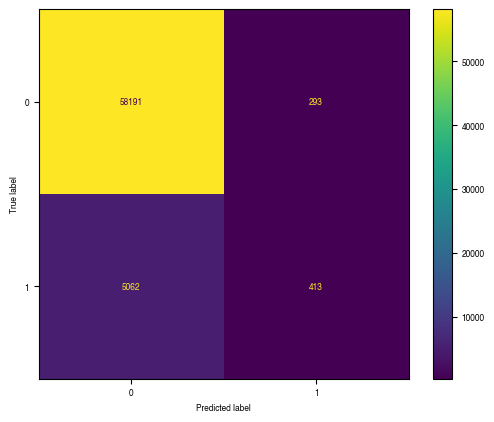



Classification Report
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     58484
         1.0       0.58      0.08      0.13      5475

    accuracy                           0.92     63959
   macro avg       0.75      0.54      0.54     63959
weighted avg       0.89      0.92      0.89     63959
 

AUC-ROC
0.8439658038619


In [258]:
eval_on_test(lgb_model, X_test_o, Y_test_o, 'LightGB', 'Initial Data')

#### SMOTE Oversample: With Outliers

In [259]:
%%time
lgb_model.fit(X_train_o_smt, Y_train_o_smt)

CPU times: user 13.3 s, sys: 1.53 s, total: 14.8 s
Wall time: 8.95 s


LGBMClassifier(learning_rate=0.05, max_depth=5, random_state=50)

Confusion Matrix
TN=54070, FP=4414, FN=3201, TP=2274


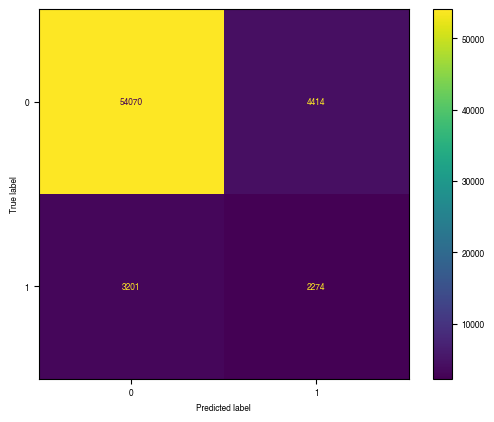



Classification Report
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93     58484
         1.0       0.34      0.42      0.37      5475

    accuracy                           0.88     63959
   macro avg       0.64      0.67      0.65     63959
weighted avg       0.89      0.88      0.89     63959
 

AUC-ROC
0.8342351340521966


In [260]:
eval_on_test(lgb_model, X_test_o, Y_test_o, 'LightGB', 'SMOTE with Outliers')

#### SMOTE Oversample: Without Outliers

In [261]:
%%time
lgb_model.fit(X_train_no_smt, Y_train_no_smt)

CPU times: user 12.2 s, sys: 1.07 s, total: 13.3 s
Wall time: 6.8 s


LGBMClassifier(learning_rate=0.05, max_depth=5, random_state=50)

Confusion Matrix
TN=52480, FP=3449, FN=3223, TP=1871


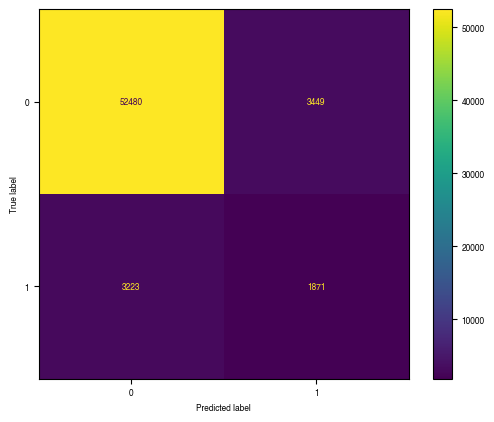



Classification Report
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     55929
         1.0       0.35      0.37      0.36      5094

    accuracy                           0.89     61023
   macro avg       0.65      0.65      0.65     61023
weighted avg       0.89      0.89      0.89     61023
 

AUC-ROC
0.8351982531725628


In [262]:
eval_on_test(lgb_model, X_test_no, Y_test_no, 'LightGB', 'SMOTE w/o Outliers')

#### ADASYN Oversample: With Outliers

In [263]:
%%time
lgb_model.fit(X_train_o_ads, Y_train_o_ads)

CPU times: user 11.3 s, sys: 926 ms, total: 12.3 s
Wall time: 6.51 s


LGBMClassifier(learning_rate=0.05, max_depth=5, random_state=50)

Confusion Matrix
TN=50997, FP=7487, FN=2532, TP=2943


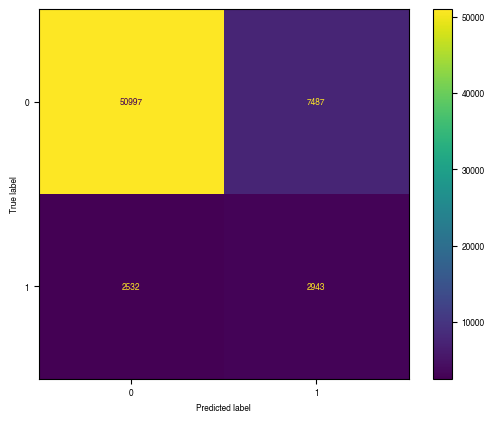



Classification Report
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     58484
         1.0       0.28      0.54      0.37      5475

    accuracy                           0.84     63959
   macro avg       0.62      0.70      0.64     63959
weighted avg       0.90      0.84      0.86     63959
 

AUC-ROC
0.828642426184393


In [264]:
eval_on_test(lgb_model, X_test_o, Y_test_o, 'LightGB', 'ADASYN with Outliers')

#### ADASYN Oversample: Without Outliers

In [265]:
%%time
lgb_model.fit(X_train_no_ads, Y_train_no_ads)

CPU times: user 10.8 s, sys: 821 ms, total: 11.6 s
Wall time: 5.9 s


LGBMClassifier(learning_rate=0.05, max_depth=5, random_state=50)

Confusion Matrix
TN=49229, FP=6700, FN=2480, TP=2614


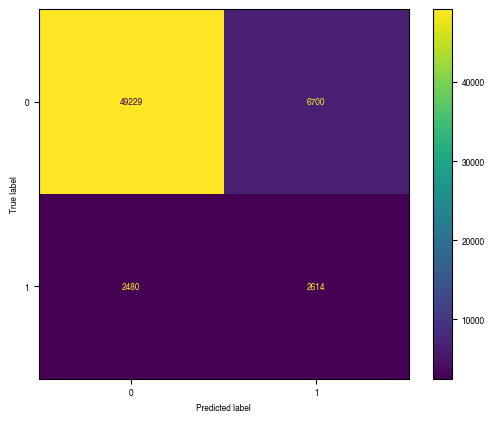



Classification Report
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     55929
         1.0       0.28      0.51      0.36      5094

    accuracy                           0.85     61023
   macro avg       0.62      0.70      0.64     61023
weighted avg       0.90      0.85      0.87     61023
 

AUC-ROC
0.8286008816228478


In [266]:
eval_on_test(lgb_model, X_test_no, Y_test_no, 'LightGB', 'ADASYN w/o Outliers')

## XGBoost Model

#### Inital Data : With Outliers and No Sampling

In [267]:
%%time

# define the model with hyperparameters
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=50)

# fit the model on training data
xgb_model.fit(X_train_o, Y_train_o)

CPU times: user 1min 30s, sys: 2.56 s, total: 1min 32s
Wall time: 42.4 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=50, ...)

Confusion Matrix
TN=58230, FP=254, FN=5098, TP=377


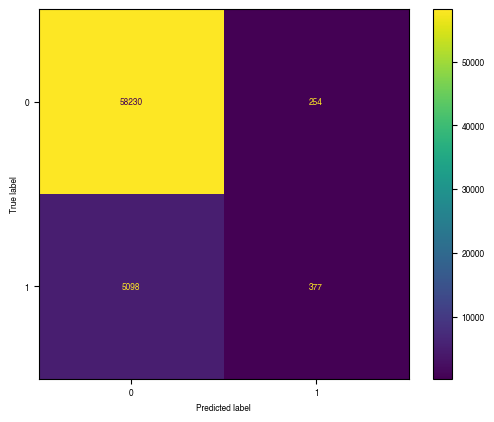



Classification Report
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     58484
         1.0       0.60      0.07      0.12      5475

    accuracy                           0.92     63959
   macro avg       0.76      0.53      0.54     63959
weighted avg       0.89      0.92      0.88     63959
 

AUC-ROC
0.8428524134454758


In [268]:
eval_on_test(xgb_model, X_test_o, Y_test_o, 'XGBoost', 'Initial Data')

#### SMOTE Oversample: With Outliers

In [269]:
%%time

# fit the model on training data
xgb_model.fit(X_train_o_smt, Y_train_o_smt)

CPU times: user 3min 23s, sys: 27.4 s, total: 3min 51s
Wall time: 2min 35s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=50, ...)

Confusion Matrix
TN=54337, FP=4147, FN=3270, TP=2205


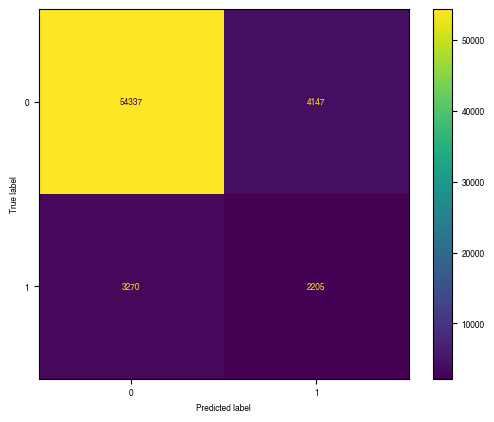



Classification Report
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94     58484
         1.0       0.35      0.40      0.37      5475

    accuracy                           0.88     63959
   macro avg       0.65      0.67      0.65     63959
weighted avg       0.89      0.88      0.89     63959
 

AUC-ROC
0.8342559132591859


In [270]:
eval_on_test(xgb_model, X_test_o, Y_test_o, 'XGBoost', 'SMOTE with Outliers')

#### SMOTE Oversample: Without Outliers

In [271]:
%%time

# fit the model on training data
xgb_model.fit(X_train_no_smt, Y_train_no_smt)

CPU times: user 3min 12s, sys: 2.96 s, total: 3min 15s
Wall time: 1min


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=50, ...)

Confusion Matrix
TN=52279, FP=3650, FN=3173, TP=1921


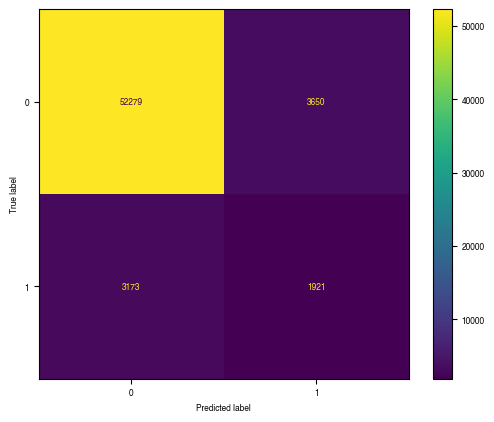



Classification Report
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94     55929
         1.0       0.34      0.38      0.36      5094

    accuracy                           0.89     61023
   macro avg       0.64      0.66      0.65     61023
weighted avg       0.89      0.89      0.89     61023
 

AUC-ROC
0.8355443559979921


In [272]:
eval_on_test(xgb_model, X_test_no, Y_test_no, 'XGBoost', 'SMOTE w/o Outliers')

#### ADASYN Oversample: With Outliers

In [273]:
%%time

# fit the model on training data
xgb_model.fit(X_train_o_ads, Y_train_o_ads)

CPU times: user 3min 15s, sys: 3.44 s, total: 3min 19s
Wall time: 1min 6s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=50, ...)

Confusion Matrix
TN=50958, FP=7526, FN=2536, TP=2939


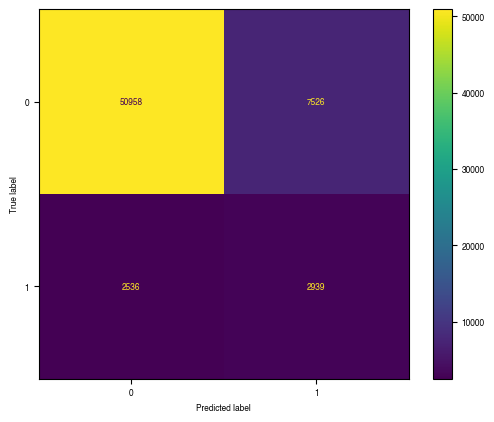



Classification Report
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     58484
         1.0       0.28      0.54      0.37      5475

    accuracy                           0.84     63959
   macro avg       0.62      0.70      0.64     63959
weighted avg       0.90      0.84      0.86     63959
 

AUC-ROC
0.8276438328056941


In [274]:
eval_on_test(xgb_model, X_test_o, Y_test_o, 'XGBoost', 'ADASYN with Outliers')

#### ADASYN Oversample: Without Outliers

In [275]:
%%time

# fit the model on training data
xgb_model.fit(X_train_no_ads, Y_train_no_ads)

CPU times: user 3min 1s, sys: 2.48 s, total: 3min 3s
Wall time: 55.3 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=50, ...)

Confusion Matrix
TN=49295, FP=6634, FN=2506, TP=2588


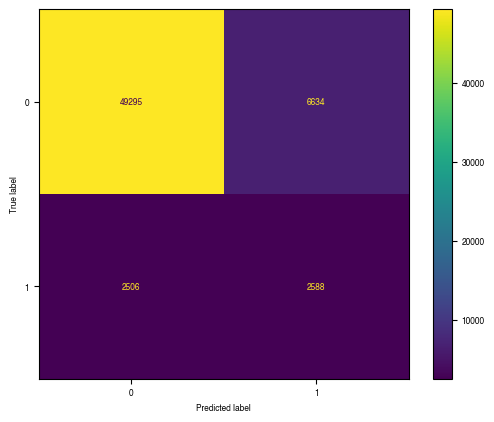



Classification Report
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.92     55929
         1.0       0.28      0.51      0.36      5094

    accuracy                           0.85     61023
   macro avg       0.62      0.69      0.64     61023
weighted avg       0.90      0.85      0.87     61023
 

AUC-ROC
0.828709590809027


In [276]:
eval_on_test(xgb_model, X_test_no, Y_test_no, 'XGBoost', 'ADASYN w/o Outliers')

## Random Forest Model

#### Inital Data : With Outliers and No Sampling

In [277]:
%%time

# Initialize the random forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=50)

# Fit the model to the training data
rf_model.fit(X_train_o, Y_train_o)


CPU times: user 26.4 s, sys: 844 ms, total: 27.2 s
Wall time: 30.5 s


RandomForestClassifier(max_depth=10, random_state=50)

Confusion Matrix
TN=58345, FP=139, FN=5245, TP=230


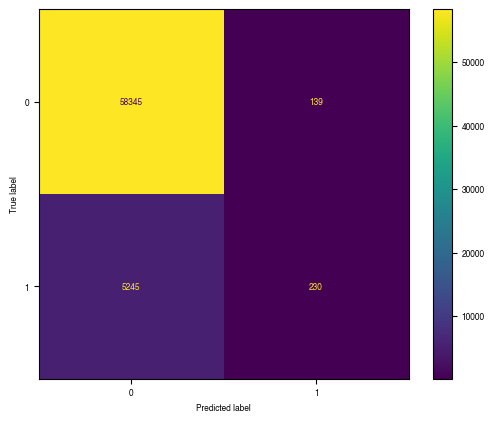



Classification Report
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     58484
         1.0       0.62      0.04      0.08      5475

    accuracy                           0.92     63959
   macro avg       0.77      0.52      0.52     63959
weighted avg       0.89      0.92      0.88     63959
 

AUC-ROC
0.8417654299704653


In [278]:
eval_on_test(rf_model, X_test_o, Y_test_o, 'Random Forest', 'Initial Data')

#### SMOTE Oversample: With Outliers

In [279]:
%%time

# Fit the model to the training data
rf_model.fit(X_train_o_smt, Y_train_o_smt)

CPU times: user 1min 24s, sys: 1.66 s, total: 1min 26s
Wall time: 1min 33s


RandomForestClassifier(max_depth=10, random_state=50)

Confusion Matrix
TN=48888, FP=9596, FN=2050, TP=3425


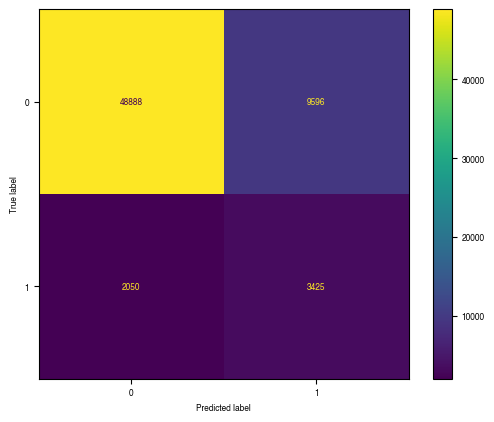



Classification Report
              precision    recall  f1-score   support

         0.0       0.96      0.84      0.89     58484
         1.0       0.26      0.63      0.37      5475

    accuracy                           0.82     63959
   macro avg       0.61      0.73      0.63     63959
weighted avg       0.90      0.82      0.85     63959
 

AUC-ROC
0.8336426307441069


In [280]:
eval_on_test(rf_model, X_test_o, Y_test_o, 'Random Forest', 'SMOTE with Outliers')

#### SMOTE Oversample: Without Outliers

In [281]:
%%time

# Fit the model to the training data
rf_model.fit(X_train_no_smt, Y_train_no_smt)

CPU times: user 1min 20s, sys: 1.85 s, total: 1min 22s
Wall time: 1min 27s


RandomForestClassifier(max_depth=10, random_state=50)

Confusion Matrix
TN=46905, FP=9024, FN=1985, TP=3109


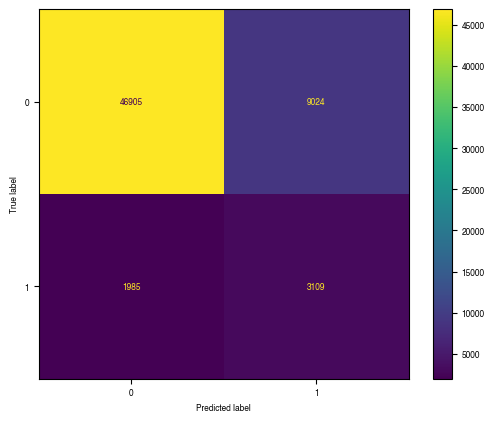



Classification Report
              precision    recall  f1-score   support

         0.0       0.96      0.84      0.89     55929
         1.0       0.26      0.61      0.36      5094

    accuracy                           0.82     61023
   macro avg       0.61      0.72      0.63     61023
weighted avg       0.90      0.82      0.85     61023
 

AUC-ROC
0.8332163353415374


In [282]:
eval_on_test(rf_model, X_test_no, Y_test_no, 'Random Forest', 'SMOTE w/o Outliers')

#### ADASYN Oversample: With Outliers

In [283]:
%%time

# Fit the model to the training data
rf_model.fit(X_train_o_ads, Y_train_o_ads)

CPU times: user 1min 23s, sys: 2.72 s, total: 1min 26s
Wall time: 1min 46s


RandomForestClassifier(max_depth=10, random_state=50)

Confusion Matrix
TN=45623, FP=12861, FN=1579, TP=3896


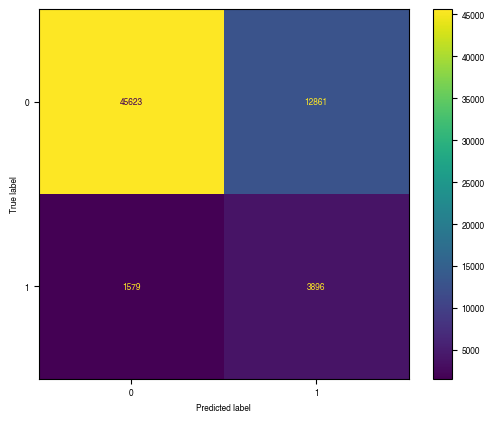



Classification Report
              precision    recall  f1-score   support

         0.0       0.97      0.78      0.86     58484
         1.0       0.23      0.71      0.35      5475

    accuracy                           0.77     63959
   macro avg       0.60      0.75      0.61     63959
weighted avg       0.90      0.77      0.82     63959
 

AUC-ROC
0.8328700336883303


In [284]:
eval_on_test(rf_model, X_test_o, Y_test_o, 'Random Forest', 'ADASYN with Outliers')

#### ADASYN Oversample: Without Outliers

In [285]:
%%time

# Fit the model to the training data
rf_model.fit(X_train_no_ads, Y_train_no_ads)

CPU times: user 1min 9s, sys: 1.59 s, total: 1min 10s
Wall time: 1min 17s


RandomForestClassifier(max_depth=10, random_state=50)

Confusion Matrix
TN=43705, FP=12224, FN=1495, TP=3599


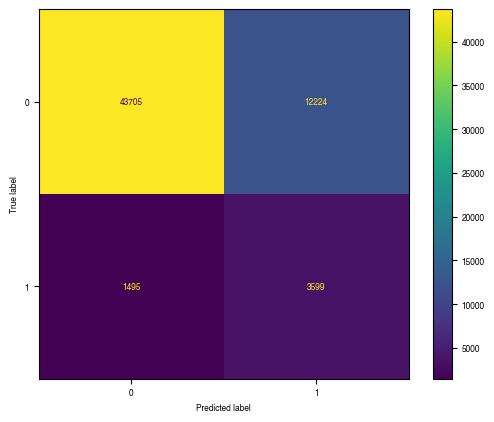



Classification Report
              precision    recall  f1-score   support

         0.0       0.97      0.78      0.86     55929
         1.0       0.23      0.71      0.34      5094

    accuracy                           0.78     61023
   macro avg       0.60      0.74      0.60     61023
weighted avg       0.91      0.78      0.82     61023
 

AUC-ROC
0.8308735078561625


In [286]:
eval_on_test(rf_model, X_test_no, Y_test_no, 'Random Forest', 'ADASYN w/o Outliers')

## Logistic Regression Model (With Built-in Cross-Validation)

#### Inital Data : With Outliers and No Sampling

In [287]:
%%time

lr_model = LogisticRegressionCV(Cs=10, cv=5, class_weight='balanced', dual=False, 
                          fit_intercept=True, intercept_scaling=1, 
                          l1_ratios=None, max_iter=100, multi_class='auto', 
                          n_jobs=None, penalty='l2', random_state=91, 
                          solver='liblinear', tol=0.0001, verbose=0)

lr_model.fit(X_train_o, Y_train_o)

CPU times: user 45.8 s, sys: 2.02 s, total: 47.8 s
Wall time: 50 s


LogisticRegressionCV(class_weight='balanced', cv=5, intercept_scaling=1,
                     random_state=91, solver='liblinear')

Confusion Matrix
TN=43886, FP=14598, FN=1220, TP=4255


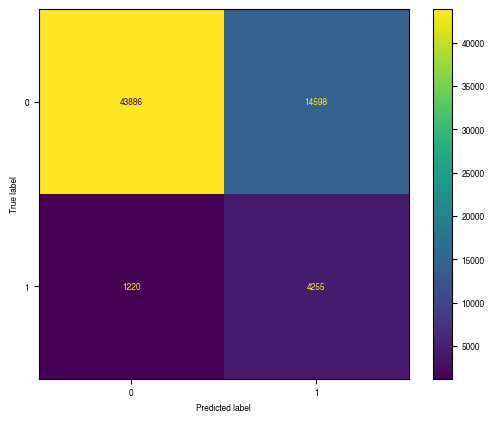



Classification Report
              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85     58484
         1.0       0.23      0.78      0.35      5475

    accuracy                           0.75     63959
   macro avg       0.60      0.76      0.60     63959
weighted avg       0.91      0.75      0.80     63959
 

AUC-ROC
0.8420194353589742


In [288]:
eval_on_test(lr_model, X_test_o, Y_test_o, 'Logistic RegressionCV', 'Initial Data')

#### SMOTE Oversample: With Outliers

In [289]:
%%time
lr_model.fit(X_train_o_smt, Y_train_o_smt)

CPU times: user 1min 7s, sys: 7.59 s, total: 1min 15s
Wall time: 1min 27s


LogisticRegressionCV(class_weight='balanced', cv=5, intercept_scaling=1,
                     random_state=91, solver='liblinear')

Confusion Matrix
TN=43676, FP=14808, FN=1210, TP=4265


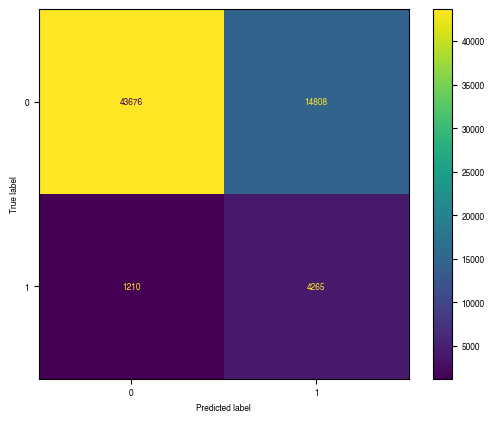



Classification Report
              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85     58484
         1.0       0.22      0.78      0.35      5475

    accuracy                           0.75     63959
   macro avg       0.60      0.76      0.60     63959
weighted avg       0.91      0.75      0.80     63959
 

AUC-ROC
0.8405910182982568


In [290]:
eval_on_test(lr_model, X_test_o, Y_test_o, 'Logistic RegressionCV', 'SMOTE with Outliers')

#### SMOTE Oversample: Without Outliers

In [291]:
%%time
lr_model.fit(X_train_no_smt, Y_train_no_smt)

CPU times: user 1min 1s, sys: 5.61 s, total: 1min 7s
Wall time: 1min 11s


LogisticRegressionCV(class_weight='balanced', cv=5, intercept_scaling=1,
                     random_state=91, solver='liblinear')

Confusion Matrix
TN=41582, FP=14347, FN=1104, TP=3990


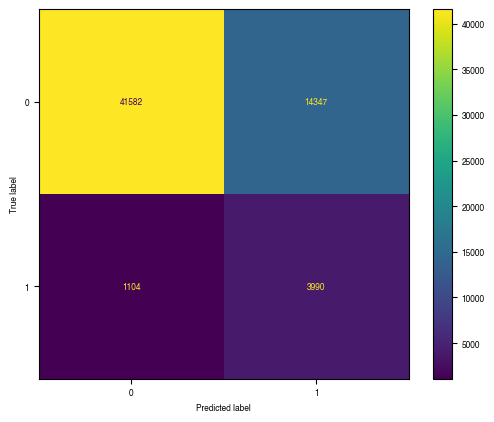



Classification Report
              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84     55929
         1.0       0.22      0.78      0.34      5094

    accuracy                           0.75     61023
   macro avg       0.60      0.76      0.59     61023
weighted avg       0.91      0.75      0.80     61023
 

AUC-ROC
0.8405121445024637


In [292]:
eval_on_test(lr_model, X_test_no, Y_test_no, 'Logistic RegressionCV', 'SMOTE w/o Outliers')

#### ADASYN Oversample: With Outliers

In [293]:
%%time
lr_model.fit(X_train_o_ads, Y_train_o_ads)

CPU times: user 1min 2s, sys: 5.87 s, total: 1min 8s
Wall time: 1min 10s


LogisticRegressionCV(class_weight='balanced', cv=5, intercept_scaling=1,
                     random_state=91, solver='liblinear')

Confusion Matrix
TN=41742, FP=16742, FN=1011, TP=4464


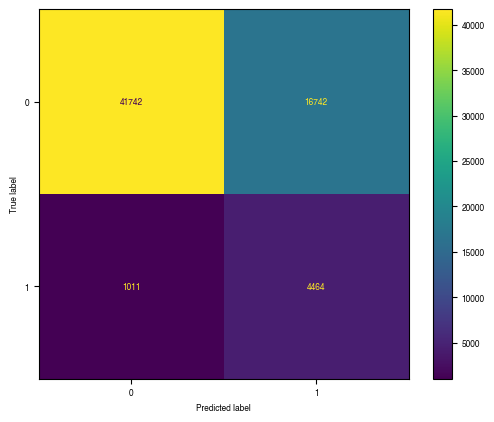



Classification Report
              precision    recall  f1-score   support

         0.0       0.98      0.71      0.82     58484
         1.0       0.21      0.82      0.33      5475

    accuracy                           0.72     63959
   macro avg       0.59      0.76      0.58     63959
weighted avg       0.91      0.72      0.78     63959
 

AUC-ROC
0.8413163901675171


In [294]:
eval_on_test(lr_model, X_test_o, Y_test_o, 'Logistic RegressionCV', 'ADASYN with Outliers')

#### ADASYN Oversample: Without Outliers

In [295]:
%%time
lr_model.fit(X_train_no_ads, Y_train_no_ads)

CPU times: user 1min 7s, sys: 9.26 s, total: 1min 16s
Wall time: 1min 39s


LogisticRegressionCV(class_weight='balanced', cv=5, intercept_scaling=1,
                     random_state=91, solver='liblinear')

Confusion Matrix
TN=39676, FP=16253, FN=904, TP=4190


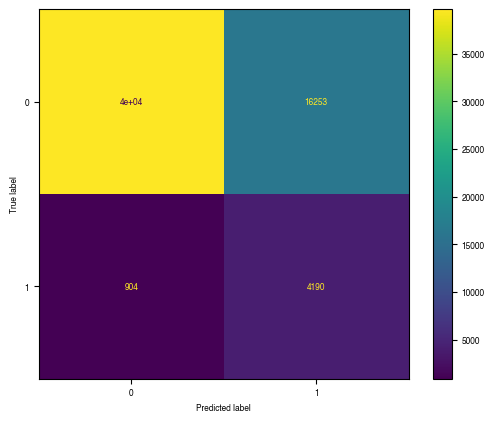



Classification Report
              precision    recall  f1-score   support

         0.0       0.98      0.71      0.82     55929
         1.0       0.20      0.82      0.33      5094

    accuracy                           0.72     61023
   macro avg       0.59      0.77      0.58     61023
weighted avg       0.91      0.72      0.78     61023
 

AUC-ROC
0.8411576534478697


In [296]:
eval_on_test(lr_model, X_test_no, Y_test_no, 'Logistic RegressionCV', 'ADASYN w/o Outliers')

# <span style="color:#87CEEB"> Results and Comparisons</span>

In [297]:
model_eval_df = pd.DataFrame({'Model':clf,
                            'Data Sample':sample,
                            'Accuracy':accuracy,
                            'Precision':precision,
                            'Recall':recall,
                            'F1-score':F1score,
                            'AUC-ROC':AUCROC})
model_eval_df

Model           Data Sample  Accuracy  Precision  \
0                 LightGB          Initial Data  0.916274   0.584986   
1                 LightGB   SMOTE with Outliers  0.880939   0.340012   
2                 LightGB    SMOTE w/o Outliers  0.890664   0.351692   
3                 LightGB  ADASYN with Outliers  0.843353   0.282167   
4                 LightGB   ADASYN w/o Outliers  0.849565   0.280653   
5                 XGBoost          Initial Data  0.916321   0.597464   
6                 XGBoost   SMOTE with Outliers  0.884035   0.347135   
7                 XGBoost    SMOTE w/o Outliers  0.888190   0.344821   
8                 XGBoost  ADASYN with Outliers  0.842680   0.280841   
9                 XGBoost   ADASYN w/o Outliers  0.850220   0.280633   
10          Random Forest          Initial Data  0.915821   0.623306   
11          Random Forest   SMOTE with Outliers  0.817915   0.263037   
12          Random Forest    SMOTE w/o Outliers  0.819593   0.256243   
13          Random Forest  ADASYN with Outliers  0.774230   0.232500   
14          Random Forest   ADASYN w/o Outliers  0.775183   0.227454   
15  Logistic RegressionCV          Initial Data  0.752685   0.225694   
16  Logistic RegressionCV   SMOTE with Outliers  0.749558   0.223615   
17  Logistic RegressionCV    SMOTE w/o Outliers  0.746800   0.217593   
18  Logistic RegressionCV  ADASYN with Outliers  0.722432   0.210506   
19  Logistic RegressionCV   ADASYN w/o Outliers  0.718844   0.204960   

      Recall  F1-score   AUC-ROC  
0   0.075434  0.133635  0.843966  
1   0.415342  0.373921  0.834235  
2   0.367295  0.359324  0.835198  
3   0.537534  0.370072  0.828642  
4   0.513153  0.362854  0.828601  
5   0.068858  0.123485  0.842852  
6   0.402740  0.372876  0.834256  
7   0.377110  0.360244  0.835544  
8   0.536804  0.368758  0.827644  
9   0.508049  0.361554  0.828710  
10  0.042009  0.078713  0.841765  
11  0.625571  0.370350  0.833643  
12  0.610326  0.360945  0.833216  
13  0.711598  0.350486  0.832870  
14  0.706517  0.344122  0.830874  
15  0.777169  0.349803  0.842019  
16  0.778995  0.347482  0.840591  
17  0.783274  0.340574  0.840512  
18  0.815342  0.334620  0.841316  
19  0.822536  0.328151  0.841158

In [ ]:
%%time

from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(solver='lbfgs')
model.fit(X_train_smt, Y_train_smt)
print(f"Model type: {model}")

In [ ]:
# Evaluate model on training dataset
train_accuracy = accuracy_score(Y_train_smt, model.predict(X_train_smt))
print("Training Accuracy:", round(train_accuracy, 4))

# Evaluate model on testing dataset
test_accuracy = accuracy_score(Y_test, model.predict(X_test))
print("Testing Accuracy:", round(test_accuracy, 4))

In [ ]:
%%time

model = LogisticRegressionCV(solver='lbfgs')
model.fit(X_train_ads, Y_train_ads)
print(f"Model type: {model}")

In [ ]:
# Evaluate model on training dataset
train_accuracy = accuracy_score(Y_train_ads, model.predict(X_train_ads))
print("Training Accuracy:", round(train_accuracy, 4))

# Evaluate model on testing dataset
test_accuracy = accuracy_score(Y_test, model.predict(X_test))
print("Testing Accuracy:", round(test_accuracy, 4))

In [ ]:
%%time

model = LogisticRegressionCV(solver='lbfgs')
model.fit(X_train, Y_train)
print(f"Model type: {model}")

# Evaluate model on training dataset
train_accuracy = accuracy_score(Y_train, model.predict(X_train))
print("Training Accuracy:", round(train_accuracy, 4))

# Evaluate model on testing dataset
test_accuracy = accuracy_score(Y_test, model.predict(X_test))
print("Testing Accuracy:", round(test_accuracy, 4))

In [ ]:
%%time

from sklearn import svm

#Create a svm Classifier
ml = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
ml.fit(X_train_smt, Y_train_smt)

#Predict the response for test dataset
y_pred = ml.predict(X_test)

In [ ]:
ml.score(X_test,Y_test)

In [ ]:
model = list()
resample = list()
precision = list()
recall = list()
F1score = list()
AUCROC = list()

In [ ]:
def test_eval(clf_model, X_test, Y_test, algo=None, sampling=None):
    # Test set prediction
    Y_prob=clf_model.predict_proba(X_test)
    Y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(Y_test,Y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(Y_test,Y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(Y_test, Y_prob[:,1]))
          
    model.append(algo)
    precision.append(precision_score(Y_test,Y_pred))
    recall.append(recall_score(Y_test,Y_pred))
    F1score.append(f1_score(Y_test,Y_pred))
    AUCROC.append(roc_auc_score(Y_test, Y_prob[:,1]))
    resample.append(sampling)

In [ ]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

log_model=LogisticRegression()

params={'C':np.logspace(-10, 1, 15),'class_weight':[None,'balanced'],'penalty':['l1','l2']}

cv = StratifiedKFold(n_splits=5, random_state=91, shuffle=True)

# Create grid search using 5-fold cross validation
clf_LR = GridSearchCV(log_model, params, cv=cv, scoring='roc_auc', n_jobs=-1)
clf_LR.fit(X_train_smt, Y_train_smt)
clf_LR.best_estimator_